# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
import scipy
from scipy.stats import spearmanr, pearsonr
import scanpy as sc

In [3]:
# Set seeds
scvi.settings.seed = 0
scvi.settings.verbosity = logging.WARNING

Global seed set to 0


In [4]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False

In [5]:
warnings.resetwarnings()

# Import data

Data paths

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [8]:
aire = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_TECs.h5ad")
aire_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/aire",
    adata=aire,
)

fezf2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_TECs.h5ad")
fezf2_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/fezf2",
    adata=fezf2,
)

adatas = {"Aire": aire, "Fezf2": fezf2,}
models = {"Aire": aire_model, "Fezf2": fezf2_model}

In [9]:
fezf2_regulated_genes_data=pd.read_csv("../../analysis/Fezf2_microarray_DE_genes.csv", index_col=0)
fezf2_regulated_genes_data["-10logp"] = -1*np.log10(fezf2_regulated_genes_data["adj.P.Val"])

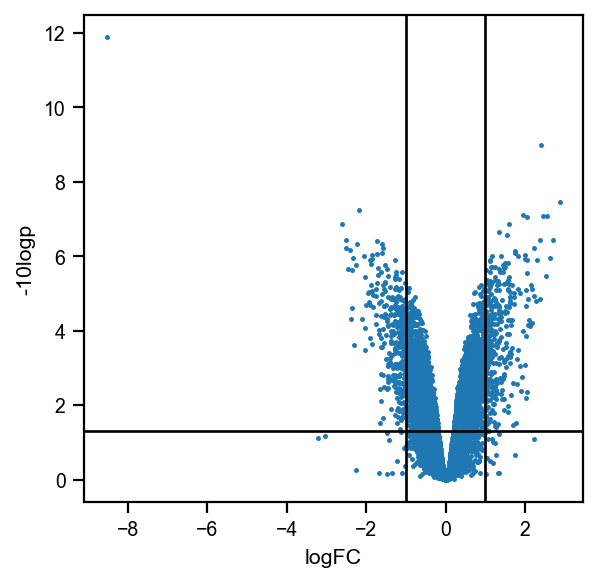

In [10]:
sns.scatterplot(
    fezf2_regulated_genes_data,
    x="logFC",
    y="-10logp",
    linewidth=0,
    s=5
)
plt.axhline(y=-1*np.log10(0.05), c="black")
plt.axvline(x=-1, c="black")
plt.axvline(x=1, c="black")
plt.show()

In [11]:
fezf2_regulated_genes_data = fezf2_regulated_genes_data[fezf2_regulated_genes_data["adj.P.Val"] < 0.05]
fezf2_regulated_genes_data = fezf2_regulated_genes_data[abs(fezf2_regulated_genes_data.logFC) > 2]
fezf2_regulated_genes_data = fezf2_regulated_genes_data[fezf2_regulated_genes_data.symbols != "Fezf2"]

In [12]:
fezf2_regulated_genes = fezf2_regulated_genes_data.symbols.unique()

# scVI DE

In [13]:
def scvi_cell_type_de(adata, model, cell_type_key, group_key, condition_group, control_group, min_cells, collapse_on=None):
    all_genes = pd.DataFrame()

    for cell_type in adata.obs[cell_type_key].unique():
        subset_data = adata[adata.obs[cell_type_key] == cell_type].copy()
        num_control = sum([i == control_group for i in subset_data.obs[group_key]])
        num_condition = sum([i == condition_group for i in subset_data.obs[group_key]])
        if num_control > min_cells and num_condition > min_cells:
            print(cell_type)
            de_genes = model.differential_expression(
                adata=subset_data,
                groupby=group_key,
                group1=condition_group,
                group2=control_group,
                silent=True,
                # filter_outlier_cells=True,
                # delta=True
            )
            de_genes["cell_type"] = cell_type
            all_genes = pd.concat([all_genes, de_genes])
        else:
            print(f"{cell_type} had too few cells in at least one group, skipping")

    all_genes["gene"] = all_genes.index
    all_genes.index = all_genes.index + "_" + all_genes.cell_type
    all_genes = all_genes.sort_index()
    all_genes["abs_lfc"] = abs(all_genes.lfc_mean)
    
    if collapse_on is not None:
        all_genes_max = all_genes.sort_values(by=collapse_on, ascending=False).drop_duplicates('gene')
        all_genes_max.index = [i[0] for i in all_genes_max.index.str.split("_")]
        return all_genes, all_genes_max
    else:
        return all_genes

def filter_scvi_de_genes(adata, df, bayes_thresh, lfc_thresh, nonzero_thresh, percentile, cell_type_key, expression_layer, peak_expression_thresh, ylim=None, collapse_on="abs_lfc", *args, **kwargs):
    for cell_type in df.cell_type.unique():
        expression = rna.tl.get_expression_matrix(
            adata[adata.obs[cell_type_key] == cell_type],
            expression_layer
        )
        percentile_expression = pd.DataFrame(np.quantile(expression, percentile, axis=0), index=[f"{i}_{cell_type}" for i in expression.columns])
        df.loc[percentile_expression.index, f"expression_{percentile}"] = percentile_expression[0]
    detected_genes = df[df[f"expression_{percentile}"] > peak_expression_thresh].copy()
    detected_genes = detected_genes[
        (detected_genes.non_zeros_proportion1 > nonzero_thresh) |
        (detected_genes.non_zeros_proportion2 > nonzero_thresh)
    ]
    
    ax = sns.scatterplot(
        x=detected_genes.lfc_mean,
        y=detected_genes.bayes_factor,
        linewidth=0,
        s=1,
        *args, **kwargs
    )
    plt.axhline(y=bayes_thresh, c="black")
    plt.axvline(x=lfc_thresh, c="black")
    plt.axvline(x=-1*lfc_thresh, c="black")
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()
    
    filtered_genes = detected_genes[detected_genes.bayes_factor > bayes_thresh].copy()
    filtered_genes = filtered_genes[abs(filtered_genes.lfc_mean) > lfc_thresh]
    
    
    if collapse_on is not None:
        filtered_genes_max = filtered_genes.sort_values(by=collapse_on, ascending=False).drop_duplicates('gene')
        filtered_genes_max.index = [i[0] for i in filtered_genes_max.index.str.split("_")]
        
        detected_genes_max = detected_genes.sort_values(by=collapse_on, ascending=False).drop_duplicates('gene')
        detected_genes_max.index = [i[0] for i in detected_genes_max.index.str.split("_")]
        return detected_genes, detected_genes_max, filtered_genes, filtered_genes_max
    
def scvi_volcanoplot(df, gene_list, lfc_thresh=None, bayes_thresh=None, *args, **kwargs):
    ax=sns.scatterplot(
        df,
        x="lfc_mean",
        y="bayes_factor",
        s=10,
        linewidth=0,
        *args, **kwargs
    )
    for gene in gene_list:
        if gene in df.gene:
            plt.text(
                df[df.gene == gene].lfc_mean,
                df[df.gene == gene].bayes_factor,
                s=gene,
                color="black",
                fontdict={"fontsize":12},
            )
        else:
            print(f"{gene} not in DE gene dataframe")
    plt.ylabel("Bayes factor")
    plt.xlabel("LFC Mean")
    if lfc_thresh is not None:
        plt.axvline(x=lfc_thresh, color="black", linestyle="--")
        plt.axvline(x=-1*lfc_thresh, color="black", linestyle="--")
    if bayes_thresh is not None:
        plt.axhline(y=bayes_thresh, color="black", linestyle="--")
    plt.show()
    
def plot_cell_type_expression(df, plot_dictionary, gene_data, *args, **kwargs):
    for gene, cell_types in plot_dictionary.items():
        for cell_type in cell_types:
            subset_data = adata[adata.obs.majority_voting == cell_type, gene]
            data = rna.tl.get_expression_matrix(subset_data, gene_data=gene_data)
            data["genotype"] = subset_data.obs.genotype
            data["cell_type"] = subset_data.obs.majority_voting
            fig,axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'width_ratios': [1, 3]})
            sns.boxplot(
                data,
                x="cell_type",
                y=gene,
                hue="genotype",
                hue_order=["WT", "Aire_KO", "Fezf2_KO"],
                ax=axs[0],
            )
            axs[0].set_xlabel("")
            axs[0].set_ylabel(gene_data)
            ax = sns.kdeplot(
                data,
                x=gene,
                hue="genotype",
                hue_order=["WT", "Aire_KO", "Fezf2_KO"],
                ax=axs[1],
                common_norm=False,
                *args, **kwargs
            )
            plt.suptitle(f"{gene}: {cell_type}")
            axs[1].set_xlabel(gene_data)
            plt.tight_layout()
            plt.show()
            
def plot_dataset_expression(adata, gene_list, gene_data, *args, **kwargs):
    data = rna.tl.get_expression_matrix(adata[:, gene_list], gene_data=gene_data)
    data["1"] = 1
    data["genotype"] = adata.obs.genotype
    for gene in gene_list:
        fig,axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'width_ratios': [1, 3]})
        sns.boxplot(
            data,
            x="1",
            y=gene,
            hue="genotype",
            hue_order=["WT", "Aire_KO", "Fezf2_KO"],
            ax=axs[0],
        )
        axs[0].set_xticks([])
        axs[0].set_xlabel("")
        axs[0].set_ylabel(gene_data)
        sns.kdeplot(
            data,
            x=gene,
            hue="genotype",
            hue_order=["WT", "Aire_KO", "Fezf2_KO"],
            ax=axs[1],
            common_norm=False,
            log_scale=True,
            *args, **kwargs
        )
        plt.suptitle(gene)
        axs[1].set_xlabel(gene_data)
        plt.tight_layout()
        plt.show()
        
def plot_dataset_feature_plots(adata, gene_list, condition_key, condition_group, control_group, gene_data, *args, **kwargs):
    vmin = []
    vmax = []
    for gene in gene_list:
        data = adata[adata.obs[condition_key] == control_group, gene].layers[gene_data]
        if scipy.sparse.issparse(data):
            data = data.todense().tolist()
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))

    sc.pl.umap(
        adata[adata.obs[condition_key] == control_group],
        color=gene_list,
        layer=gene_data,
        vmin=vmin,
        vmax=vmax,
        *args, **kwargs
    )
    sc.pl.umap(
        adata[adata.obs[condition_key] == condition_group],
        color=gene_list,
        layer=gene_data,
        vmin=vmin,
        vmax=vmax,
        *args, **kwargs
    )

## Run DE

In [20]:
all_genes = {}
all_genes_max_lfc = {}
for key, adata in adatas.items():
    for sample in adata.obs["sample"].unique():
        print(f"{key}_{sample}")
        adata_subset = adata[adata.obs["sample"] == sample]
        all_gene, all_gene_max_lfc = scvi_cell_type_de(
            adata=adata_subset,
            model=models[key],
            cell_type_key="majority_voting",
            group_key="genotype",
            condition_group=f"{key}_KO",
            control_group=f"WT",
            collapse_on="abs_lfc",
            min_cells=30,
        )
        all_genes[f"{key}_{sample}"] = all_gene
        all_genes_max_lfc[f"{key}_{sample}"] = all_gene_max_lfc
        print()

Aire_1
Gut/Liver
Aire-stage
Immature MEC
Ciliated had too few cells in at least one group, skipping
Tuft2
Lung, basal
Tuft1
Skin, basal
Goblet had too few cells in at least one group, skipping
TA MEC
Neuroendocrine
Mcell

Aire_2
Immature MEC
Aire-stage
TA MEC
Ciliated had too few cells in at least one group, skipping
Neuroendocrine
Lung, basal
Skin, basal
Gut/Liver
Tuft2
Goblet
Mcell
Tuft1

Fezf2_1
Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC
Neuroendocrine
Skin, keratinized
Goblet
Skin, basal
Tuft1 had too few cells in at least one group, skipping
Mcell
TA MEC
Ciliated
Lung, basal
Ionocyte had too few cells in at least one group, skipping

Fezf2_2
TA MEC
Aire-stage
Neuroendocrine
Immature MEC
Tuft2
Skin, keratinized
Mcell
Gut/Liver
Goblet
Skin, basal
Tuft1 had too few cells in at least one group, skipping
Lung, basal
adult cTEC had too few cells in at least one group, skipping
Ciliated had too few cells in at least one group, skipping
Ionocyte had too few cells in at least one g

## Filter

Aire_1


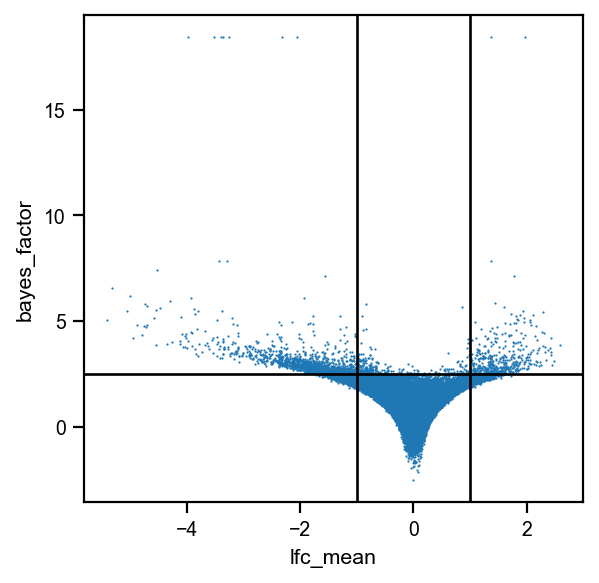

Aire_2


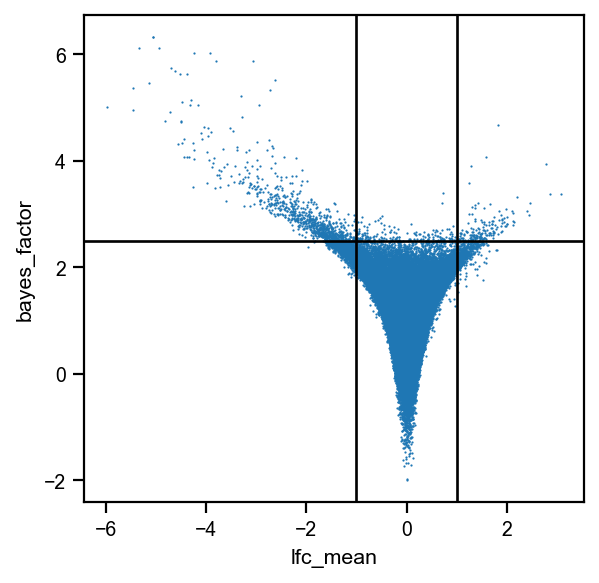

Fezf2_1


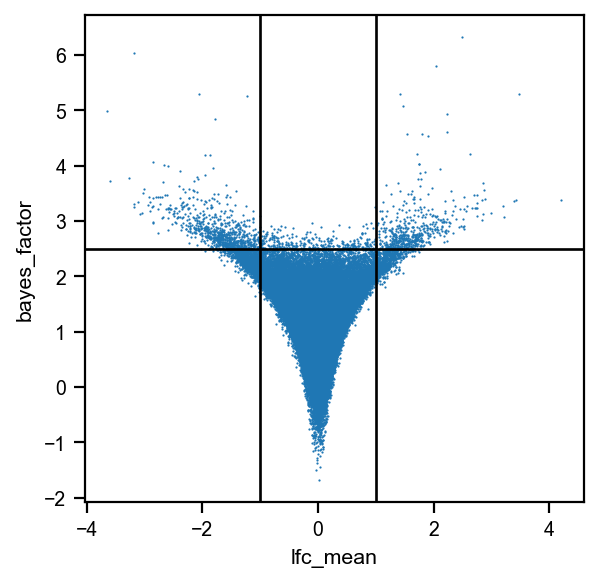

Fezf2_2


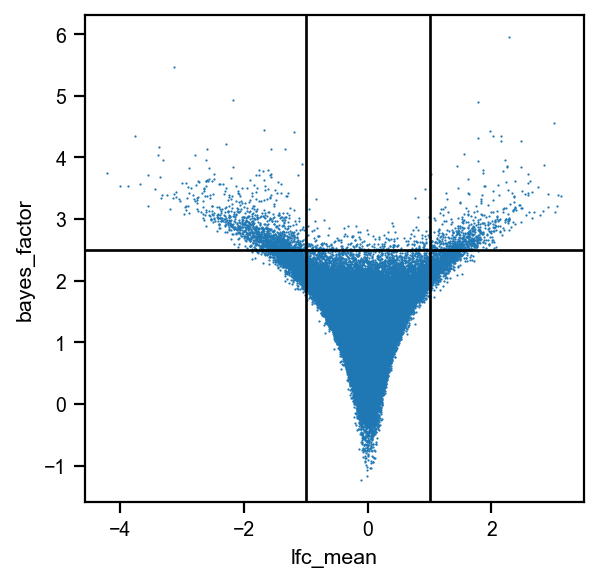

In [21]:
filtered_genes = {}
filtered_genes_max_lfc = {}
detected_genes = {}
detected_genes_max_lfc = {}
for key, adata in adatas.items():
    for sample in adata.obs["sample"].unique():
        print(f"{key}_{sample}")
        adata_subset = adata[adata.obs["sample"] == sample]
        detected_gene, detected_gene_max_lfc, filtered_gene, filtered_gene_max_lfc_ = filter_scvi_de_genes(
            adata=adata_subset,
            cell_type_key="majority_voting",
            expression_layer="scVI_normalized",
            df=all_genes[f"{key}_{sample}"],
            bayes_thresh=2.5,
            lfc_thresh=1,
            nonzero_thresh=0.1,
            percentile=0.99,
            peak_expression_thresh=0.5,
            # ylim=(0,3),
            collapse_on="abs_lfc",
        )
        detected_genes[f"{key}_{sample}"] = detected_gene
        detected_genes_max_lfc[f"{key}_{sample}"] = detected_gene_max_lfc
        filtered_genes[f"{key}_{sample}"] = filtered_gene
        filtered_genes_max_lfc[f"{key}_{sample}"] = filtered_gene_max_lfc_

## sample overlap

### Fezf2

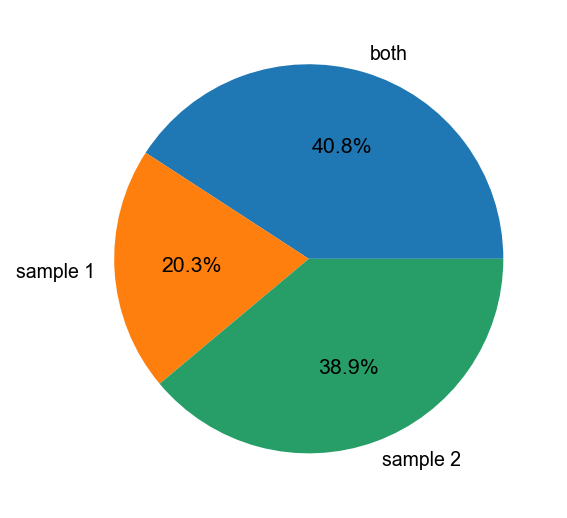

In [22]:
fezf2_1_filtered = filtered_genes_max_lfc["Fezf2_1"].copy()
fezf2_2_filtered = filtered_genes_max_lfc["Fezf2_2"].copy()

both = fezf2_1_filtered[
    fezf2_1_filtered.index.isin(fezf2_2_filtered.index)
].copy()
both.loc[:,"sample"] = "both"

sample_1 = fezf2_1_filtered[
    ~fezf2_1_filtered.index.isin(fezf2_2_filtered.index)
].copy()
sample_1.loc[:,"sample"] = "1"

sample_2 = fezf2_2_filtered[
    ~fezf2_2_filtered.index.isin(fezf2_1_filtered.index)
].copy()
sample_2.loc[:,"sample"] = "2"

fezf2_regulated = pd.concat([both, sample_1, sample_2])
fezf2_regulated["sample"] = fezf2_regulated["sample"].astype("category")
fezf2_regulated["sample"].cat = fezf2_regulated["sample"].cat.reorder_categories(["1", "2", "both"])

sizes = [both.shape[0], sample_1.shape[0], sample_2.shape[0]]
labels = ["both", "sample 1", "sample 2"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
# plt.title("Aire KO filtered DE genes")
plt.show()

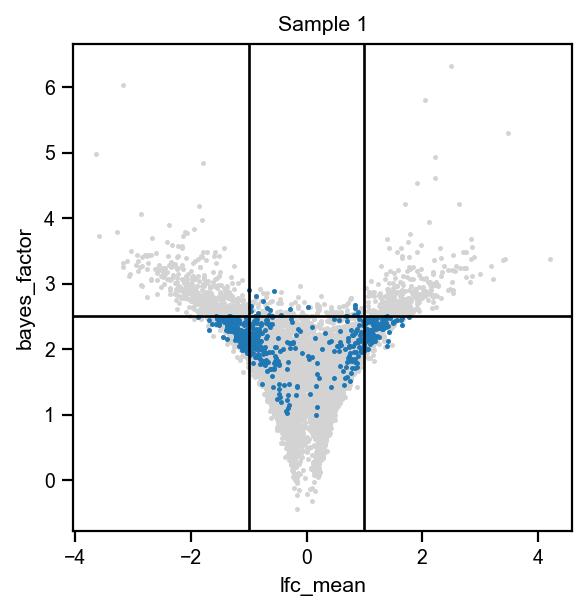

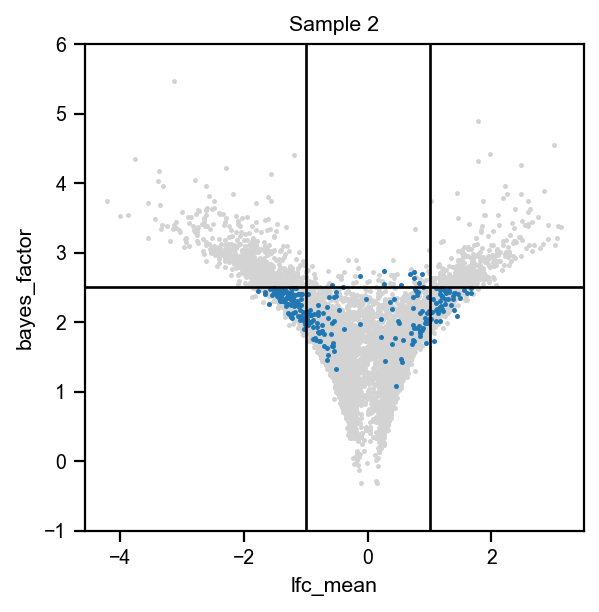

In [23]:
fezf2_1_all = detected_genes_max_lfc["Fezf2_1"].copy()
fezf2_2_all = detected_genes_max_lfc["Fezf2_2"].copy()
sns.scatterplot(
    x=fezf2_1_all.lfc_mean,
    y=fezf2_1_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=fezf2_1_all[fezf2_1_all.index.isin(sample_2.index)].lfc_mean,
    y=fezf2_1_all[fezf2_1_all.index.isin(sample_2.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.axhline(y=2.5, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 1")
plt.show()

sns.scatterplot(
    x=fezf2_2_all.lfc_mean,
    y=fezf2_2_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=fezf2_2_all[fezf2_2_all.index.isin(sample_1.index)].lfc_mean,
    y=fezf2_2_all[fezf2_2_all.index.isin(sample_1.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.ylim((-1,6))
plt.axhline(y=2.5, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 2")
plt.show()

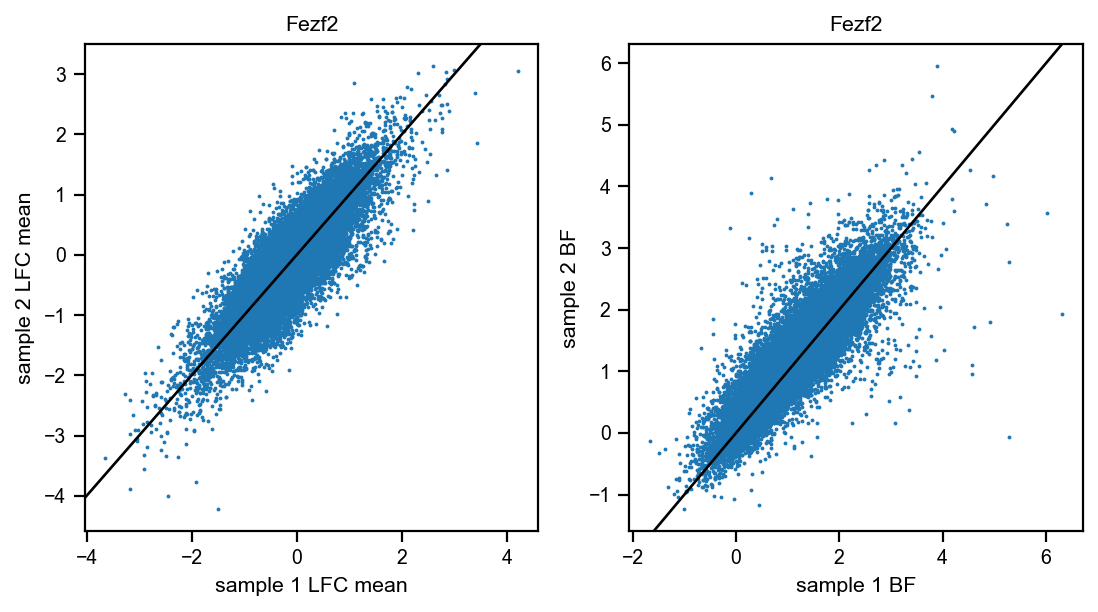

In [24]:
all_fezf2_1 = detected_genes["Fezf2_1"]
all_fezf2_2 = detected_genes["Fezf2_2"]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
ax = sns.scatterplot(
    x=all_fezf2_1.lfc_mean,
    y=all_fezf2_2.lfc_mean,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Fezf2")
ax.set_xlabel("sample 1 LFC mean")
ax.set_ylabel("sample 2 LFC mean")

plt.subplot(1,2,2)
ax = sns.scatterplot(
    x=all_fezf2_1.bayes_factor,
    y=all_fezf2_2.bayes_factor,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Fezf2")
ax.set_xlabel("sample 1 BF")
ax.set_ylabel("sample 2 BF")
plt.show()

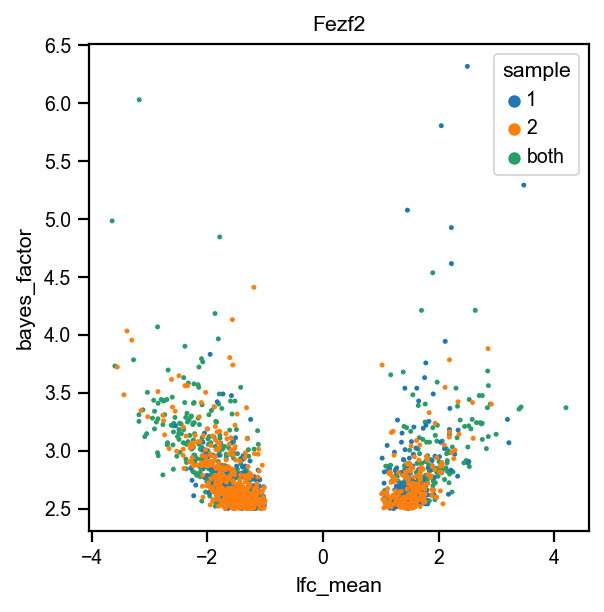

In [25]:
sns.scatterplot(
    fezf2_regulated,
    x="lfc_mean",
    y="bayes_factor",
    hue="sample",
    s=5,
    linewidth=0,
)
plt.title("Fezf2")
plt.show()

### Aire

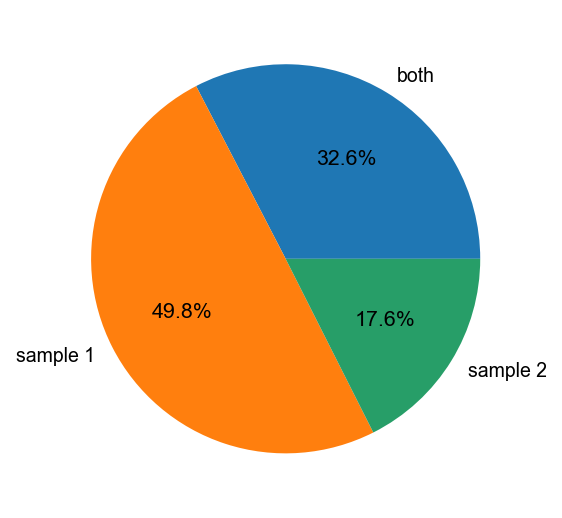

In [26]:
aire_1_filtered = filtered_genes_max_lfc["Aire_1"].copy()
aire_2_filtered = filtered_genes_max_lfc["Aire_2"].copy()

both = aire_1_filtered[
    aire_1_filtered.index.isin(aire_2_filtered.index)
].copy()
both.loc[:, "sample"] = "both"

sample_1 = aire_1_filtered[
    ~aire_1_filtered.index.isin(aire_2_filtered.index)
].copy()
sample_1.loc[:, "sample"] = "1"

sample_2 = aire_2_filtered[
    ~aire_2_filtered.index.isin(aire_1_filtered.index)
].copy()
sample_2.loc[:, "sample"] = "2"

aire_regulated = pd.concat([sample_1, sample_2, both])
aire_regulated["sample"] = aire_regulated["sample"].astype("category")
aire_regulated["sample"].cat = aire_regulated["sample"].cat.reorder_categories(["1", "2", "both"])

sizes = [both.shape[0], sample_1.shape[0], sample_2.shape[0]]
labels = ["both", "sample 1", "sample 2"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
# plt.title("Aire KO filtered DE genes")
plt.show()

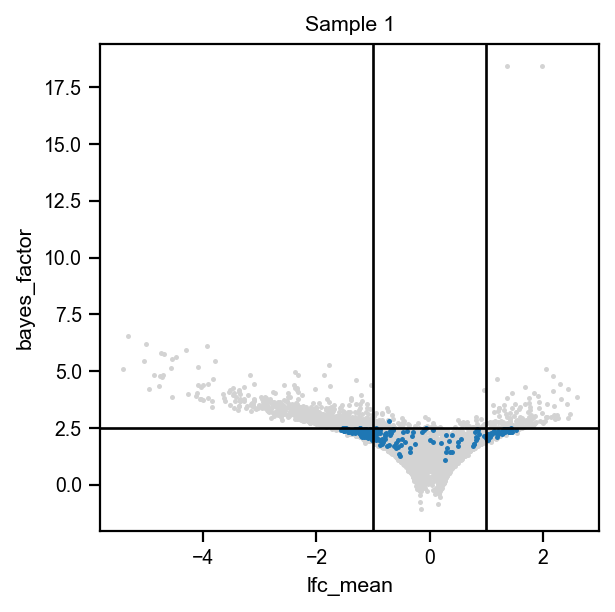

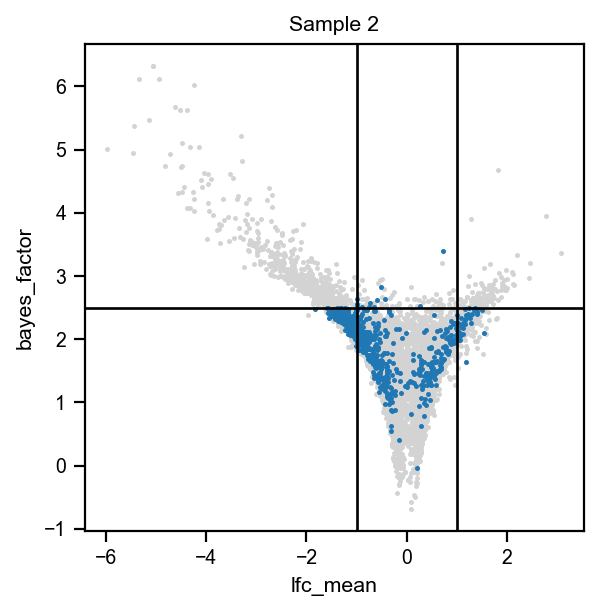

In [27]:
aire_1_all = detected_genes_max_lfc["Aire_1"].copy()
aire_2_all = detected_genes_max_lfc["Aire_2"].copy()
sns.scatterplot(
    x=aire_1_all.lfc_mean,
    y=aire_1_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=aire_1_all[aire_1_all.index.isin(sample_2.index)].lfc_mean,
    y=aire_1_all[aire_1_all.index.isin(sample_2.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.axhline(y=2.5, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 1")
plt.show()

sns.scatterplot(
    x=aire_2_all.lfc_mean,
    y=aire_2_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=aire_2_all[aire_2_all.index.isin(sample_1.index)].lfc_mean,
    y=aire_2_all[aire_2_all.index.isin(sample_1.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.axhline(y=2.5, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 2")
plt.show()

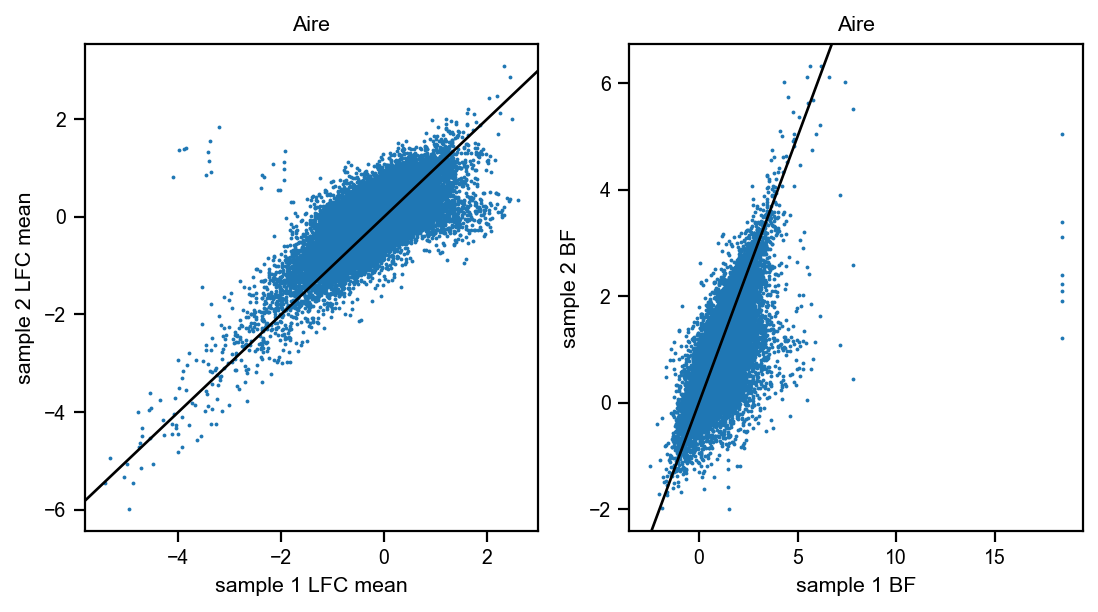

In [28]:
all_aire_1 = detected_genes["Aire_1"]
all_aire_2 = detected_genes["Aire_2"]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
ax = sns.scatterplot(
    x=all_aire_1.lfc_mean,
    y=all_aire_2.lfc_mean,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Aire")
ax.set_xlabel("sample 1 LFC mean")
ax.set_ylabel("sample 2 LFC mean")

plt.subplot(1,2,2)
ax = sns.scatterplot(
    x=all_aire_1.bayes_factor,
    y=all_aire_2.bayes_factor,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Aire")
ax.set_xlabel("sample 1 BF")
ax.set_ylabel("sample 2 BF")
plt.show()

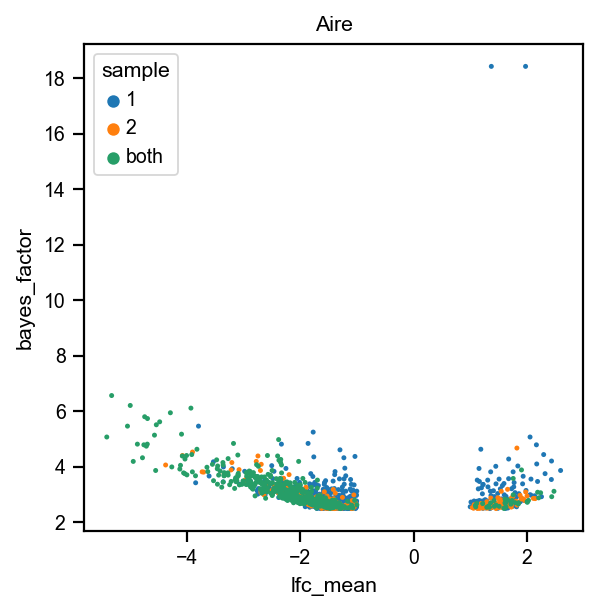

In [29]:
sns.scatterplot(
    aire_regulated,
    x="lfc_mean",
    y="bayes_factor",
    hue="sample",
    s=5,
    linewidth=0,
)
plt.title("Aire")
plt.show()

## fezf2 regulated genes

In [30]:
aire_regulated[aire_regulated.index.isin(fezf2_regulated_genes)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene,abs_lfc,expression_0.99,sample
St3gal4,0.9470,0.0530,2.883007,0.000038,0.000144,0.0,0.25,-1.992691,-2.051036,1.947529,...,1.128182,True,Aire_KO vs WT,Aire_KO,WT,"Lung, basal",St3gal4,1.992691,5.080780,1
Scel,0.9308,0.0692,2.599043,0.000011,0.000048,0.0,0.25,-1.814380,-1.760553,1.936301,...,0.447275,True,Aire_KO vs WT,Aire_KO,WT,"Lung, basal",Scel,1.814380,2.384173,1
Cyp2f2,0.9334,0.0666,2.640129,0.000034,0.000080,0.0,0.25,-1.688667,-1.750130,1.675114,...,0.758165,True,Aire_KO vs WT,Aire_KO,WT,Immature MEC,Cyp2f2,1.688667,3.316500,1
Sbsn,0.9394,0.0606,2.740946,0.000043,0.000099,0.0,0.25,-1.599954,-1.755123,1.706725,...,0.728392,True,Aire_KO vs WT,Aire_KO,WT,Aire-stage,Sbsn,1.599954,3.750132,1
Calb1,0.9352,0.0648,2.669455,0.000030,0.000087,0.0,0.25,-1.516903,-1.556918,1.017946,...,0.973405,True,Aire_KO vs WT,Aire_KO,WT,Aire-stage,Calb1,1.516903,2.070173,1
Ttr,0.9408,0.0592,2.765809,0.000123,0.000063,0.0,0.25,1.125123,1.026736,2.983518,...,0.312760,True,Aire_KO vs WT,Aire_KO,WT,Mcell,Ttr,1.125123,6.247676,1
Fetub,0.9346,0.0654,2.659596,0.000079,0.000038,0.0,0.25,1.069209,1.130154,2.746407,...,0.425673,True,Aire_KO vs WT,Aire_KO,WT,Gut/Liver,Fetub,1.069209,3.223412,1
Ly6g6c,0.9716,0.0284,3.532555,0.000008,0.000057,0.0,0.25,-2.974430,-3.116524,1.914473,...,0.307778,True,Aire_KO vs WT,Aire_KO,WT,Aire-stage,Ly6g6c,2.974430,2.394180,2
Klk1b16,0.9316,0.0684,2.611531,0.000076,0.000169,0.0,0.25,-1.372769,-1.375743,2.504078,...,1.997247,True,Aire_KO vs WT,Aire_KO,WT,Gut/Liver,Klk1b16,1.372769,9.097050,2
Apoc3,0.9706,0.0294,3.496919,0.000023,0.000081,0.0,0.25,-3.012575,-3.245646,2.468992,...,0.838837,True,Aire_KO vs WT,Aire_KO,WT,Aire-stage,Apoc3,3.012575,5.158811,both


In [31]:
aire_regulated["fezf2_microarray_de"] = aire_regulated.index.isin(fezf2_regulated_genes)

In [32]:
fezf2_regulated[fezf2_regulated.index.isin(fezf2_regulated_genes)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene,abs_lfc,expression_0.99,sample
Krt10,0.9932,0.0068,4.984008,0.000189,0.002384,0.0,0.25,-3.644091,-3.736726,1.380505,...,43.992704,True,Fezf2_KO vs WT,Fezf2_KO,WT,"Skin, keratinized",Krt10,3.644091,56.921958,both
Fabp9,0.9628,0.0372,3.253537,0.000058,0.000400,0.0,0.25,-3.180677,-3.079609,2.626119,...,6.694518,True,Fezf2_KO vs WT,Fezf2_KO,WT,Gut/Liver,Fabp9,3.180677,21.133513,both
Il18,0.9756,0.0244,3.688469,0.000089,0.000012,0.0,0.25,2.850214,3.088231,1.542654,...,0.017551,True,Fezf2_KO vs WT,Fezf2_KO,WT,Mcell,Il18,2.850214,2.229393,both
Apoc3,0.9618,0.0382,3.225971,0.000055,0.000391,0.0,0.25,-2.766443,-2.695962,1.978393,...,7.235160,True,Fezf2_KO vs WT,Fezf2_KO,WT,Mcell,Apoc3,2.766443,17.022135,both
Ttr,0.9688,0.0312,3.435640,0.000060,0.000349,0.0,0.25,-2.738081,-2.752189,3.828506,...,9.182222,True,Fezf2_KO vs WT,Fezf2_KO,WT,Gut/Liver,Ttr,2.738081,34.026923,both
Arg1,0.9854,0.0146,4.212025,0.000622,0.000106,0.0,0.25,2.635422,2.699756,1.183098,...,0.433609,True,Fezf2_KO vs WT,Fezf2_KO,WT,"Skin, keratinized",Arg1,2.635422,14.662507,both
Krtap3-3,0.9460,0.0540,2.863258,0.000067,0.000007,0.0,0.25,2.532647,2.361124,2.270512,...,0.033458,True,Fezf2_KO vs WT,Fezf2_KO,WT,"Skin, keratinized",Krtap3-3,2.532647,4.724162,both
Bbox1,0.9602,0.0398,3.183274,0.000022,0.000096,0.0,0.25,-2.488414,-2.298954,1.819917,...,1.112233,True,Fezf2_KO vs WT,Fezf2_KO,WT,"Skin, keratinized",Bbox1,2.488414,2.157581,both
Smtnl1,0.9602,0.0398,3.183274,0.000053,0.000269,0.0,0.25,-2.406380,-2.370586,1.602509,...,2.541649,True,Fezf2_KO vs WT,Fezf2_KO,WT,Gut/Liver,Smtnl1,2.406380,8.570758,both
Wfdc15b,0.9672,0.0328,3.383976,0.000084,0.000016,0.0,0.25,2.328825,2.378948,1.240436,...,0.008964,True,Fezf2_KO vs WT,Fezf2_KO,WT,Mcell,Wfdc15b,2.328825,1.594606,both


In [33]:
fezf2_regulated["fezf2_microarray_de"] = fezf2_regulated.index.isin(fezf2_regulated_genes)

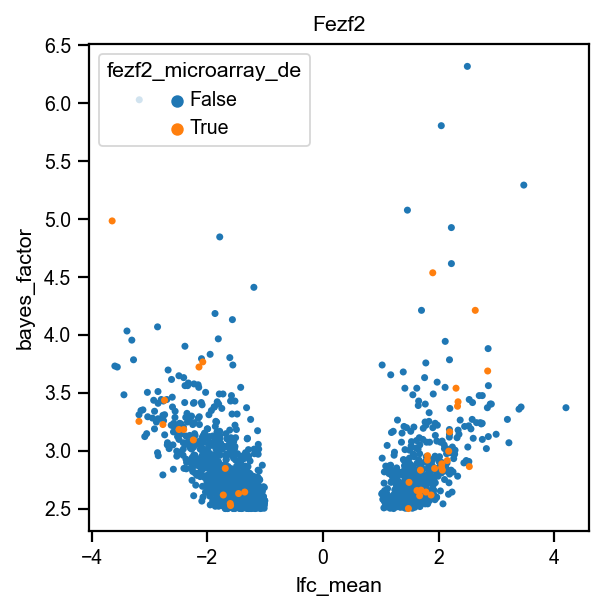

In [34]:
sns.scatterplot(
    fezf2_regulated[~fezf2_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
sns.scatterplot(
    fezf2_regulated[fezf2_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    palette=["tab:orange"],
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
plt.title("Fezf2")
plt.show()

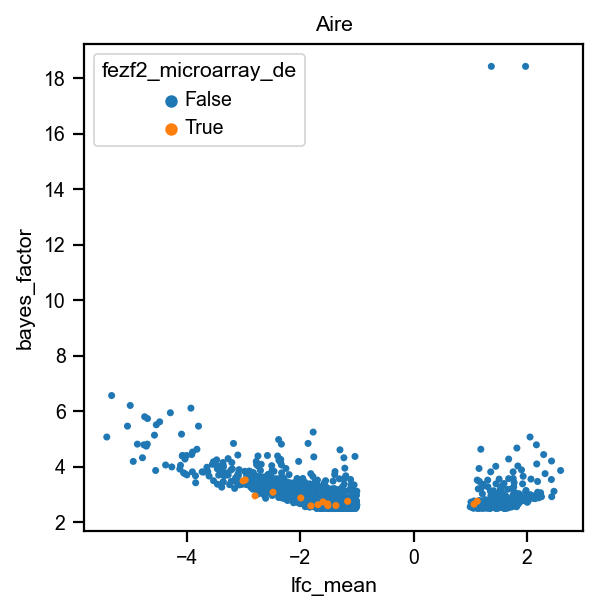

In [35]:
sns.scatterplot(
    aire_regulated[~aire_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
sns.scatterplot(
    aire_regulated[aire_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    palette=["tab:orange"],
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
plt.title("Aire")
plt.show()

# Num regulated genes comparison

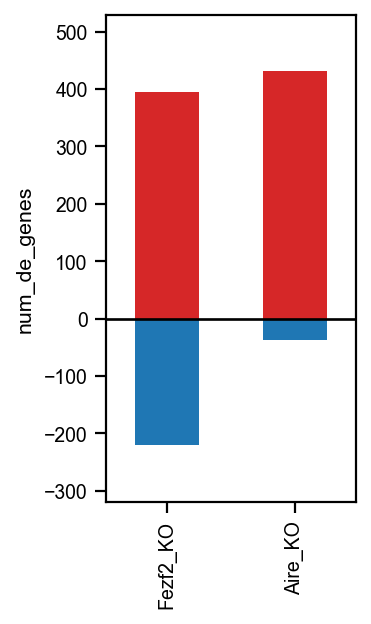

In [36]:
plotData = {}
plotData["up"] = [sum(fezf2_regulated[fezf2_regulated["sample"] == "both"].lfc_mean > 0), sum(aire_regulated[aire_regulated["sample"] == "both"].lfc_mean > 0)]
plotData["down"] = [sum(fezf2_regulated[fezf2_regulated["sample"] == "both"].lfc_mean < 0), sum(aire_regulated[aire_regulated["sample"] == "both"].lfc_mean < 0)]

plotData = pd.DataFrame(plotData, index=["Fezf2_KO", "Aire_KO"])

fig=plt.figure(figsize=(2,4))
plt.bar(x=plotData.index, height=plotData.down, color='tab:red', width=0.5)
plt.bar(x=plotData.index, height=-plotData.up, color='tab:blue', width=0.5)
plt.xticks([0,1], plotData.index, rotation='vertical')
plt.ylabel("num_de_genes")
plt.axhline(y=0, c="black")
plt.margins(0.15)
plt.show()

In [37]:
print(f"Aire KO up: {aire_regulated[(aire_regulated.lfc_mean > 0) & (aire_regulated['sample'] == 'both')].shape[0]}")
print(f"Aire KO down: {aire_regulated[(aire_regulated.lfc_mean < 0) & (aire_regulated['sample'] == 'both')].shape[0]}")
print(f"Fezf2 KO up: {fezf2_regulated[(fezf2_regulated.lfc_mean > 0) & (fezf2_regulated['sample'] == 'both')].shape[0]}")
print(f"Fezf2 KO down: {fezf2_regulated[(fezf2_regulated.lfc_mean < 0) & (fezf2_regulated['sample'] == 'both')].shape[0]}")

Aire KO up: 37
Aire KO down: 431
Fezf2 KO up: 221
Fezf2 KO down: 395


# WT data

## Aire

In [38]:
aire_WT_all_genes, aire_WT_all_genes_max_lfc = scvi_cell_type_de(
    adata=adatas["Aire"],
    model=models["Aire"],
    cell_type_key="majority_voting",
    group_key="batch",
    condition_group="Aire_WT-1",
    control_group="Aire_WT-2",
    collapse_on="abs_lfc",
    min_cells=30,
)

Gut/Liver
Aire-stage
Immature MEC
Ciliated


/home/joe/miniconda3/envs/fezf2-thymus/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 1 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


Tuft2
Lung, basal
Tuft1
Skin, basal
Goblet had too few cells in at least one group, skipping
TA MEC
Neuroendocrine
Mcell


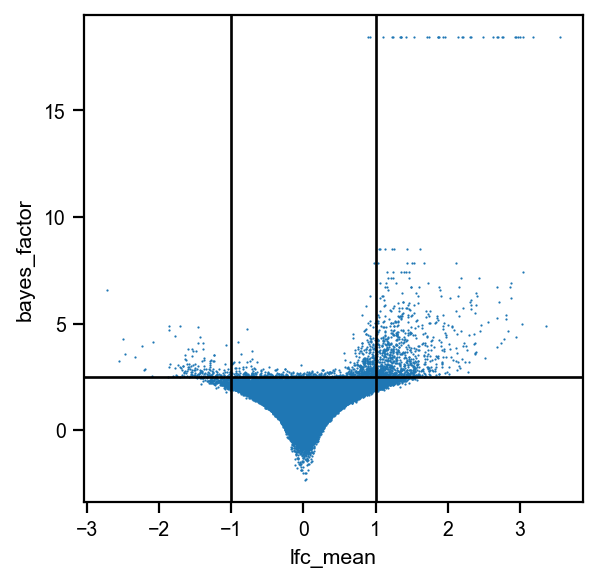

In [39]:
aire_WT_detected_genes, aire_WT_detected_genes_max_lfc, aire_WT_filtered_genes, aire_WT_filtered_genes_max_lfc = filter_scvi_de_genes(
    adata=aire[aire.obs.batch.isin(["Aire_WT-1", "Aire_WT-2"])],
    cell_type_key="majority_voting",
    expression_layer="scVI_normalized",
    df=aire_WT_all_genes,
    bayes_thresh=2.5,
    lfc_thresh=1,
    nonzero_thresh=0.1,
    percentile=0.99,
    peak_expression_thresh=0.5,
    # ylim=(0,3),
    collapse_on="abs_lfc",
)

In [40]:
aire_regulated = aire_regulated[~aire_regulated.index.isin(aire_WT_filtered_genes_max_lfc.index)]

In [41]:
aire_regulated["sample"].value_counts()/aire_regulated.shape[0]

1       0.489706
both    0.334559
2       0.175735
Name: sample, dtype: float64

In [42]:
print(f"Aire KO up: {aire_regulated[(aire_regulated.lfc_mean > 0) & (aire_regulated['sample'] == 'both')].shape[0]}")
print(f"Aire KO down: {aire_regulated[(aire_regulated.lfc_mean < 0) & (aire_regulated['sample'] == 'both')].shape[0]}")

Aire KO up: 35
Aire KO down: 420


## Fezf2

In [43]:
fezf2_WT_all_genes, fezf2_WT_all_genes_max_lfc = scvi_cell_type_de(
    adata=adatas["Fezf2"],
    model=models["Fezf2"],
    cell_type_key="majority_voting",
    group_key="batch",
    condition_group="Fezf2_WT-1",
    control_group="Fezf2_WT-2",
    collapse_on="abs_lfc",
    min_cells=30,
)

Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC had too few cells in at least one group, skipping
Neuroendocrine
Skin, keratinized
Goblet
Skin, basal
Tuft1
Mcell
TA MEC
Ciliated
Lung, basal
Ionocyte had too few cells in at least one group, skipping


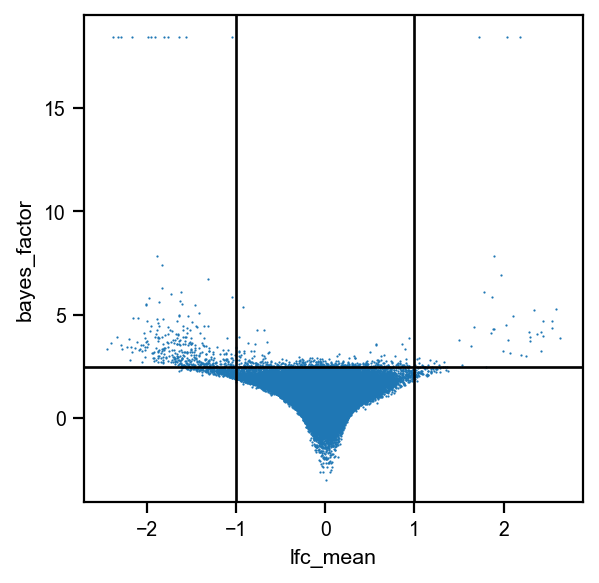

In [44]:
fezf2_WT_detected_genes, fezf2_WT_detected_genes_max_lfc, fezf2_WT_filtered_genes, fezf2_WT_filtered_genes_max_lfc = filter_scvi_de_genes(
    adata=fezf2[fezf2.obs.batch.isin(["Fezf2_WT-1", "Fezf2_WT-2"])],
    cell_type_key="majority_voting",
    expression_layer="scVI_normalized",
    df=fezf2_WT_all_genes,
    bayes_thresh=2.5,
    lfc_thresh=1,
    nonzero_thresh=0.1,
    percentile=0.99,
    peak_expression_thresh=0.5,
    # ylim=(0,3),
    collapse_on="abs_lfc",
)

In [45]:
fezf2_regulated = fezf2_regulated[~fezf2_regulated.index.isin(fezf2_WT_filtered_genes_max_lfc.index)]

In [46]:
fezf2_regulated["sample"].value_counts()/fezf2_regulated.shape[0]

both    0.415301
2       0.381148
1       0.203552
Name: sample, dtype: float64

In [47]:
print(f"Fezf2 KO up: {fezf2_regulated[(fezf2_regulated.lfc_mean > 0) & (fezf2_regulated['sample'] == 'both')].shape[0]}")
print(f"Fezf2 KO down: {fezf2_regulated[(fezf2_regulated.lfc_mean < 0) & (fezf2_regulated['sample'] == 'both')].shape[0]}")

Fezf2 KO up: 219
Fezf2 KO down: 389


# KO data

## Aire

In [48]:
aire_KO_all_genes, aire_KO_all_genes_max_lfc = scvi_cell_type_de(
    adata=adatas["Aire"],
    model=models["Aire"],
    cell_type_key="majority_voting",
    group_key="batch",
    condition_group="Aire_KO-1",
    control_group="Aire_KO-2",
    collapse_on="abs_lfc",
    min_cells=30,
)

Gut/Liver
Aire-stage
Immature MEC
Ciliated had too few cells in at least one group, skipping
Tuft2
Lung, basal
Tuft1
Skin, basal
Goblet
TA MEC
Neuroendocrine
Mcell


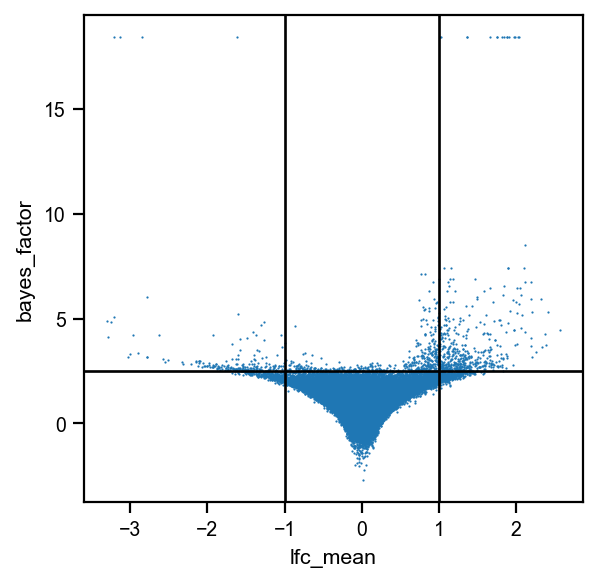

In [49]:
aire_KO_detected_genes, aire_KO_detected_genes_max_lfc, aire_KO_filtered_genes, aire_KO_filtered_genes_max_lfc = filter_scvi_de_genes(
    adata=aire[aire.obs.batch.isin(["Aire_KO-1", "Aire_KO-2"])],
    cell_type_key="majority_voting",
    expression_layer="scVI_normalized",
    df=aire_KO_all_genes,
    bayes_thresh=2.5,
    lfc_thresh=1,
    nonzero_thresh=0.1,
    percentile=0.99,
    peak_expression_thresh=0.5,
    # ylim=(0,3),
    collapse_on="abs_lfc",
)

In [50]:
aire_regulated = aire_regulated[~aire_regulated.index.isin(aire_KO_filtered_genes_max_lfc.index)]

In [51]:
aire_regulated["sample"].value_counts()/aire_regulated.shape[0]

1       0.488733
both    0.335664
2       0.175602
Name: sample, dtype: float64

In [52]:
print(f"Aire KO up: {aire_regulated[(aire_regulated.lfc_mean > 0) & (aire_regulated['sample'] == 'both')].shape[0]}")
print(f"Aire KO down: {aire_regulated[(aire_regulated.lfc_mean < 0) & (aire_regulated['sample'] == 'both')].shape[0]}")

Aire KO up: 33
Aire KO down: 399


## Fezf2

In [53]:
fezf2_KO_all_genes, fezf2_KO_all_genes_max_lfc = scvi_cell_type_de(
    adata=adatas["Fezf2"],
    model=models["Fezf2"],
    cell_type_key="majority_voting",
    group_key="batch",
    condition_group="Fezf2_KO-1",
    control_group="Fezf2_KO-2",
    collapse_on="abs_lfc",
    min_cells=30,
)

Gut/Liver
Tuft2
Immature MEC
Aire-stage
adult cTEC
Neuroendocrine
Skin, keratinized
Goblet
Skin, basal
Tuft1 had too few cells in at least one group, skipping
Mcell
TA MEC
Ciliated had too few cells in at least one group, skipping
Lung, basal
Ionocyte had too few cells in at least one group, skipping


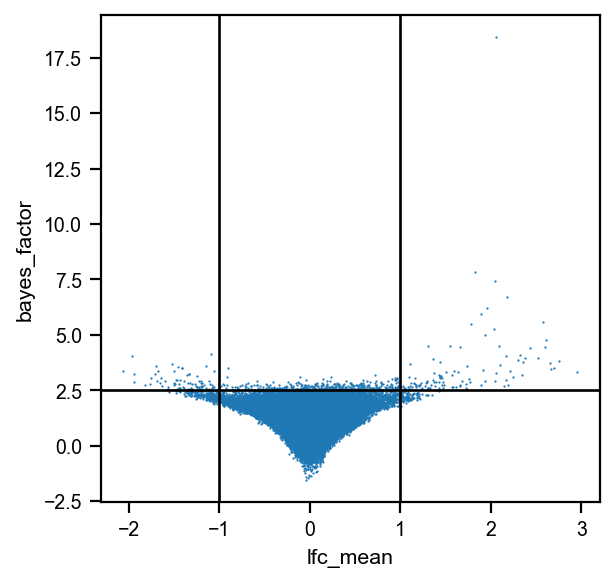

In [54]:
fezf2_KO_detected_genes, fezf2_KO_detected_genes_max_lfc, fezf2_KO_filtered_genes, fezf2_KO_filtered_genes_max_lfc = filter_scvi_de_genes(
    adata=fezf2[fezf2.obs.batch.isin(["Fezf2_KO-1", "Fezf2_KO-2"])],
    cell_type_key="majority_voting",
    expression_layer="scVI_normalized",
    df=fezf2_KO_all_genes,
    bayes_thresh=2.5,
    lfc_thresh=1,
    nonzero_thresh=0.1,
    percentile=0.99,
    peak_expression_thresh=0.5,
    # ylim=(0,3),
    collapse_on="abs_lfc",
)

In [55]:
fezf2_regulated = fezf2_regulated[~fezf2_regulated.index.isin(fezf2_KO_filtered_genes_max_lfc.index)]

In [56]:
fezf2_regulated["sample"].value_counts()/fezf2_regulated.shape[0]

both    0.419444
2       0.383333
1       0.197222
Name: sample, dtype: float64

In [57]:
print(f"Fezf2 KO up: {fezf2_regulated[(fezf2_regulated.lfc_mean > 0) & (fezf2_regulated['sample'] == 'both')].shape[0]}")
print(f"Fezf2 KO down: {fezf2_regulated[(fezf2_regulated.lfc_mean < 0) & (fezf2_regulated['sample'] == 'both')].shape[0]}")

Fezf2 KO up: 217
Fezf2 KO down: 387
